### South Pacific Ocean Parcels Simulation
Advect a set of coordinates using Ocean surface current estimates

#### Import required python libraries

In [54]:
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile
import cartopy
import numpy as np
import math
from datetime import timedelta, datetime
from operator import attrgetter
import xarray as xr
##- Custom functions
from model_utils import *
from geo_utils import *
from parcels_utils import *

#### Initialize parameters

In [55]:
run_days = 6     ##- Number of days to run simulation, if None then default to entire model time bounds
stime = None        ##- Time to begin simulation, defaults to T0 in dataset '2022-06-14T22:21:00Z'

#### Define input/output data sources

In [56]:
fname_pts = './input/south-pacific-points.txt'
fname_model = '/tmp/hycom_latest.nc'
##- Define output fname
ofname = '/tmp/hycom_parcels_output.zarr'

#### Read input points and create bounding region of interest (ROI)

In [57]:
buf = 4.0                                         ##- Buffer to extend ROI (degrees)
P = read_csv(fname_pts)                           ##- read in csv of input pts (geo_utils.py)
bbox = bounding_box(P['lat'],P['lon'],buf)        ##- compute bounding box (geo_utils.py)

In [58]:
##- Take a look at particle coordinates stored in dictionary
P

{'lat': [7.006, 11.14, 13.807, 11.07, 12.29],
 'lon': [134.586, 133.93, 144.354, 140.74, 142.56]}

#### Open and subset HYCOM model data source

In [59]:
dset = get_hycom_data(fname_model)
dset = hycom_subset(dset,bbox['lon'],bbox['lat'])

In [60]:
##- Take a look at model dset object
dset

<xarray.Dataset>
Dimensions:  (time: 57, lat: 370, lon: 230)
Coordinates:
  * time     (time) datetime64[ns] 2023-05-15T12:00:00 ... 2023-05-22T12:00:00
    depth    float64 0.0
  * lat      (lat) float64 3.04 3.08 3.12 3.16 3.2 ... 17.68 17.72 17.76 17.8
  * lon      (lon) float64 130.0 130.1 130.2 130.2 ... 148.1 148.2 148.2 148.3
Data variables:
    water_u  (time, lat, lon) float32 ...
    water_v  (time, lat, lon) float32 ...
Attributes: (12/18)
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    classification_authority:  not applicable
    institution:               Fleet Numerical Meteorology and Oceanography C...
    source:                    HYCOM archive file
    ...                        ...
    location:                  Proto fmrc:GLBy0.08_930_FMRC
    History:                   Translated to CF-1.0 Conventions by Netcdf-Jav...
    geospatial_lat_min:        1.0
    geospatial_lat_max:        40.0
    geospatial_lon_min:        110.0
    geospatial_lon_max:        170.0

#### Set up parameters for parcels to run

In [61]:
variables = { 'U':'water_u','V':'water_v'}
dimensions = { 'lat':'lat','lon':'lon','time':'time'}
start_dt = stime
if (not run_days):
    run_days = get_model_runtime(dset.time.data)

In [62]:
print("Simulation will run for "+str(run_days)+" days.")

Simulation will run for 6 days.


#### Create a Parcels FieldSet object using vars/dims

In [63]:
fieldset = FieldSet.from_xarray_dataset(dset,variables,dimensions)

#### Check out fieldset

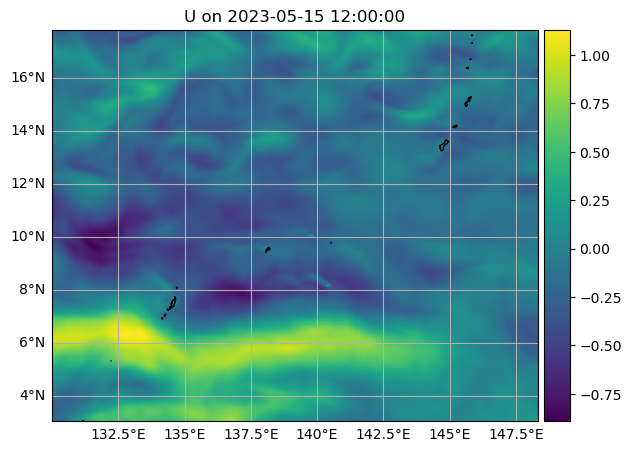

In [64]:
fieldset.U.show()

#### Create Parcels ParticleSet from input point list

In [65]:
pset = ParticleSet.from_list(fieldset=fieldset, 
                             pclass=JITParticle, 
                             lon=P['lon'], 
                             lat=P['lat'], 
                             time=start_dt)

In [66]:
##- Inspect pset object
print(pset)

P[10](lon=134.585999, lat=7.006000, depth=0.000000, time=not_yet_set)
P[11](lon=133.929993, lat=11.140000, depth=0.000000, time=not_yet_set)
P[12](lon=144.354004, lat=13.807000, depth=0.000000, time=not_yet_set)
P[13](lon=140.740005, lat=11.070000, depth=0.000000, time=not_yet_set)
P[14](lon=142.559998, lat=12.290000, depth=0.000000, time=not_yet_set)


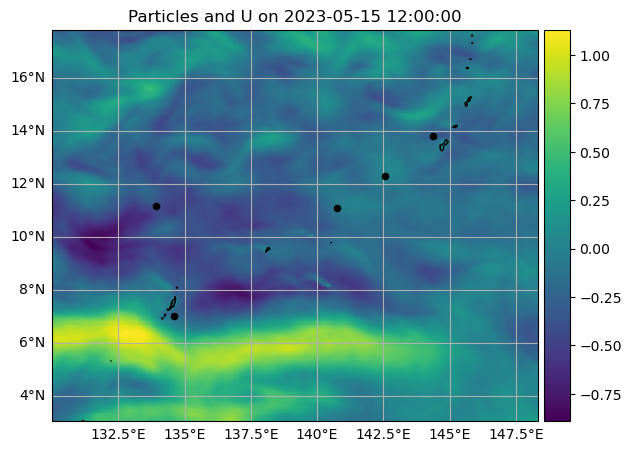

In [67]:
pset.show(field=fieldset.U)

#### Advect the particles through fieldset time/space

In [68]:
##- Will create a .zarr file in /tmp, need to convert this to netcdf
output_file = pset.ParticleFile(name=ofname, outputdt=timedelta(hours=1))
pset.execute(AdvectionRK4,
             runtime=timedelta(days=run_days),
             dt=timedelta(minutes=10),
            output_file=output_file)

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /tmp/parcels-1000/lib75aeede679551ab51c2a69b7e806e683_0.so


#### Use Parcels plotting utilities to visualize results

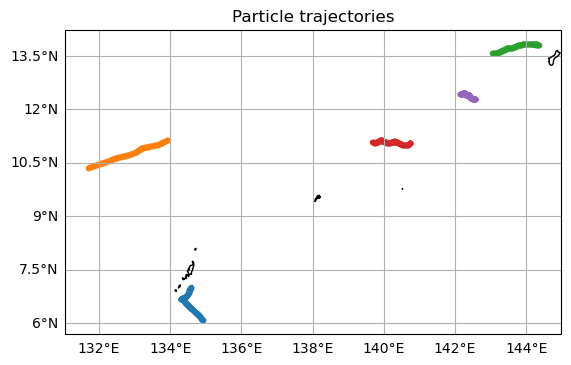

In [69]:
plotTrajectoriesFile(ofname);

In [70]:
##- Export results to netcdf
nc_fname = ofname.replace('.zarr','.nc')
zarr_to_nc(ofname,nc_fname)

Created NetCDF file: /tmp/hycom_parcels_output.nc


In [71]:
##- Write to KML
kml_fname = nc_fname.replace('.nc','.kml')
kml_dict = parcels_to_kml(nc_fname,kml_fname)
print("Created KML file: "+kml_fname)

Created KML file: /tmp/hycom_parcels_output.kml
